In [1]:
!pip install kaggle

In [5]:
!pip install plotly

In [52]:
from transformers import pipeline
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import re
from datetime import datetime

In [8]:
# ID file
file_id = "1-5_JXOnscS2zN1nEgNVKJX5wFL4uLb1L"
download_link = f"https://drive.google.com/uc?id={file_id}"

# dowload the file csv from Google drive
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [9]:
# data wraining
df.set_index('Unnamed: 0', inplace=True)
df.index.name ="ID"

In [10]:
df.head()

,time,comment
ID,,
0,0:03,was uppp everyone
1,0:05,this is it
2,0:07,bobchamp
3,0:07,Omg Im so excited for this
4,0:07,french here


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   time     16130 non-null  object
 1   comment  16130 non-null  object
dtypes: object(2)
memory usage: 378.0+ KB


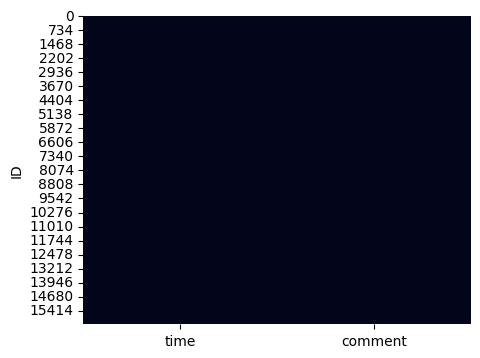

In [12]:
# there don´t present data null
plt.figure(figsize=(5, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [13]:
# Load analitic model for feelings
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
# Create function for get polarity in comments
def obtener_polaridad(comentario):
    resultado = classifier(comentario)
    return resultado[0]['label']

In [15]:
# apply the function to each comment of dataframe.
df['polarity'] = df['comment'].apply(obtener_polaridad)

In [16]:
df

,time,comment,polarity
ID,,,
0,0:03,was uppp everyone,1 star
1,0:05,this is it,5 stars
2,0:07,bobchamp,4 stars
3,0:07,Omg Im so excited for this,1 star
4,0:07,french here,3 stars
...,...,...,...
16125,2:11:41,R I P David Bowie,5 stars
16126,2:11:41,_perfect_effect_ nice to meet you,5 stars
16127,2:11:41,its finished,4 stars


In [18]:
df_original= df

In [61]:
df=df_original

In [62]:
df.head(40)

,time,comment,polarity,score,POSITIVE,CUMULATIVE_POSITIVE,NEUTRAL,CUMULATIVE_NEUTRAL,NEGATIVE,CUMULATIVE_NEGATIVE
ID,,,,,,,,,,
0,0:03,was uppp everyone,1 star,1,0,0,0,0,1,1
1,0:05,this is it,5 stars,5,1,1,0,0,0,1
2,0:07,bobchamp,4 stars,4,1,2,0,0,0,1
3,0:07,Omg Im so excited for this,1 star,1,0,2,0,0,1,2
4,0:07,french here,3 stars,3,0,2,1,1,0,2
5,0:08,History,5 stars,5,1,3,0,1,0,2
6,0:09,This Is Poggers,1 star,1,0,3,0,1,1,3
7,0:10,it s a time a to watcha tha rovar hahaaq,5 stars,5,1,4,0,1,0,3
8,0:11,this will be epic,5 stars,5,1,5,0,1,0,3


In [ ]:
# ELMININAR TODAS LAS COLUMNAS ,EXCEPTO LAS DE INTERES

In [51]:
df.describe(include=['object'])

,time
count,145170
unique,6451
top,1:33:41
freq,144


In [21]:
# function for create regular expression
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    return int(numeros[0]) if numeros else None
df['score'] = df['polarity'].apply(extraer_numeros)

In [23]:
def positive(puntuacion):
    return 1 if puntuacion in [4, 5] else 0
df['POSITIVE'] = df['score'].apply(positive)
df['CUMULATIVE_POSITIVE'] = df['POSITIVE'].cumsum()


def neutral(puntuacion):
    return 1 if puntuacion in [3] else 0
df['NEUTRAL'] = df['score'].apply(neutral)
df['CUMULATIVE_NEUTRAL'] = df['NEUTRAL'].cumsum()


def negative(puntuacion):
    return 1 if puntuacion in [1, 2] else 0
df['NEGATIVE'] = df['score'].apply(negative)
df['CUMULATIVE_NEGATIVE'] = df['NEGATIVE'].cumsum()

In [ ]:
# HACES EL GROUP BY

In [29]:
df['POSITIVE'].value_counts()

1    9553
0    6577
Name: POSITIVE, dtype: int64

In [27]:
df['NEUTRAL'].value_counts()

0    13842
1     2288
Name: NEUTRAL, dtype: int64

In [28]:
df['NEGATIVE'].value_counts()

0    11841
1     4289
Name: NEGATIVE, dtype: int64

In [42]:
df_positive = df[['time', 'CUMULATIVE_POSITIVE']]
df_positive = df_positive.rename(columns={'CUMULATIVE_POSITIVE': 'y'})

In [43]:
df_neutral = df[['time', 'CUMULATIVE_NEUTRAL']]
df_neutral = df_neutral.rename(columns={'CUMULATIVE_NEUTRAL': 'y'})

In [44]:
df_negative = df[['time', 'CUMULATIVE_NEGATIVE']]
df_negative = df_negative.rename(columns={'CUMULATIVE_NEGATIVE': 'y'})

In [47]:
import pandas as pd
import plotly.express as px

# Concatenar los conjuntos de datos
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Asignar colores a cada categoría
color_discrete_sequence = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

# GRÁFICO ANIMADO
fig = px.scatter(df, x='time', y='y', animation_frame='time', color=df.index.get_level_values(0),
                 range_x=[0, 6], range_y=[0, 3], color_discrete_sequence=[color_discrete_sequence[key] for key in df.index.get_level_values(0)])

# Personalizar la animación
fig.update_layout(
    title='Gráfica Animada con Plotly',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)

# GRÁFICO ESTÁTICO
fig_total = px.line(df, x='time', y='y', color=df.index.get_level_values(0), range_x=[0, 6], range_y=[0, 3],
                    line_dash=df.index.get_level_values(0), color_discrete_sequence=[color_discrete_sequence[key] for key in df.index.get_level_values(0)])

# Personalizar la gráfica total
fig_total.update_layout(
    title='Trayectorias del Recorrido Total',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)

# Mostrar ambas gráficas
fig.show()
fig_total.show()


Output hidden; open in https://colab.research.google.com to view.